# 1. Preprocessing

In this notebook, we apply some preprocessing steps to our image stack:
1. Import and crop.
2. Denoise time-wise.
3. Calculate absorbance and denoise space-wise.
4. Save denoised absorbance as double-precision array stack to a file.

First we import Python modules and define some paraemters.

In [1]:
# Python imports
import os
from natsort import natsorted, ns

import numpy as np

from skimage import io
from skimage.util import img_as_float
from skimage.restoration import denoise_wavelet, estimate_sigma

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets

from tqdm.notebook import tqdm

In [2]:
# folder containing the images. This should be the relative path from the python
# script.
folder = 'images'

# Reference image Python index (for example, if reference image is the first of the stack,
# leave as 0)
ref_index = 0

# Last image to take (None to take the last image)
ref_end = None

# Number of images to skip (use non-zero for testing or to speed-up processing)
skip = 0

In [3]:
# Get images names. 'natsorted' function will sort the names by 'natural' order,
# for example if there is a suffix with image number or timestamp.
list_files = natsorted(os.listdir(folder))

# Trim list
list_files = list_files[ref_index:ref_end:skip+1]
print(f"Reference image name: {list_files[0]}")
print(f"Number of images in stack: {len(list_files)}")

Reference image name: 2024-05-03_0000.tiff
Number of images in stack: 10


## Select the area of interest

Use slider handles or select and overwrite values next to each the slider.

In [5]:
# Cropping
im0 = img_as_float(io.imread(f"{folder}/{list_files[0]}"))
y_max, x_max = im0.shape
def crop(horizontal,vertical):
    im = im0[vertical[0]:vertical[1],horizontal[0]:horizontal[1]]
    
    rect = patches.Rectangle([horizontal[0], vertical[0]], horizontal[1]-horizontal[0], vertical[1]-vertical[0], linewidth=1, edgecolor='r', facecolor='none')
    
    plt.rcParams["figure.figsize"] = (15,10)
    figure, ax = plt.subplots(ncols=2)
        
    ax[0].imshow(im0, cmap='gray')
    ax[0].add_patch(rect)
    ax[0].set_title('Original image')

    ax[1].imshow(im, cmap='gray')
    ax[1].set_title('Cropped image')
    plt.show()
    
    return im

# Check for previously used values
import pickle
try:
    cuvette = pickle.load(open("cuvette.pickle", "rb" ))
except FileNotFoundError:
    cuvette = {'horizontal': (0, x_max), 'vertical': (0, y_max)}

w = interactive(crop, horizontal=widgets.IntRangeSlider(value=[cuvette['horizontal'][0], cuvette['horizontal'][1]],min=0,max=x_max, continuous_update=False),
                       vertical=widgets.IntRangeSlider(value=[cuvette['vertical'][0], cuvette['vertical'][1]],min=0,max=y_max, continuous_update=False))
w

interactive(children=(IntRangeSlider(value=(0, 1920), continuous_update=False, description='horizontal', max=1…

In [6]:
# Store selected value between runs
pickle.dump(w.kwargs, open("cuvette.pickle", "wb"))

## Load images

Images of the stack will be loaded, cropped and stored in an array of images for further processing.

In [7]:
stack = np.empty((len(list_files), *w.result.shape))

for i, name in tqdm(enumerate(list_files), total=len(list_files)):

    # Load image as matrix of floats, values in [0,1]
    im = img_as_float(io.imread(f"{folder}/{name}"))
    # Crop and store
    stack[i] = im[w.kwargs['vertical'][0]:w.kwargs['vertical'][1],w.kwargs['horizontal'][0]:w.kwargs['horizontal'][1]]

  0%|          | 0/10 [00:00<?, ?it/s]

## Time noise reduction using wavelets

The following noise reduction is based on the fact that for each pixel the intensity should be either constant (outside diffusion area) or a smooth function of time. We apply wavelet denoising with a standard algorithm from the `skimage.restoration` module. Parameters are stored in the following dictionary:

In [8]:
denoise_kwargs = {'wavelet': 'sym4', 
                  'mode': 'soft',
                  'method': 'VisuShrink'
                  }

Increase `noise_floor` to remove noise more agressively.

In [9]:
# Overwrite denoise_wavelet to force strong denoising
import pywt

noise_floor = 0.0044

def denoise_wavelet(s, sigma=0, **denoise_kwargs):
    coeffs = pywt.wavedec(s, 'sym4', mode='symmetric')
    for i in range(1,len(coeffs)):
        coeffs[i][np.abs(coeffs[i])<noise_floor] = 0
    reconstruct = pywt.waverec(coeffs, 'sym4', mode='symmetric')  
    if len(reconstruct) != len(s):
        return reconstruct[:-1]
    else:
        return reconstruct
    

First we try the filtering on a few point probes. The standard deviation of the noise is computed using `estimate_sigma`.

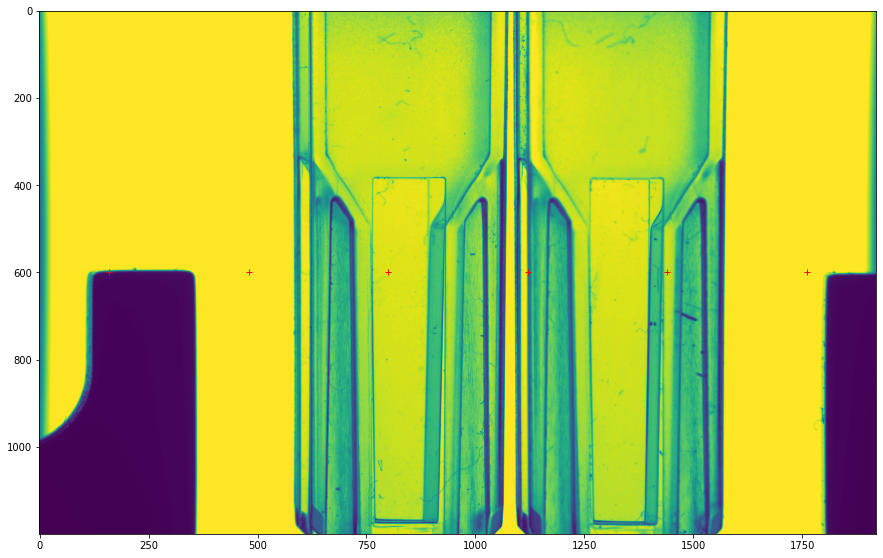

c:\users\fiam irc\appdata\local\programs\python\python39\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\users\fiam irc\appdata\local\programs\python\python39\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


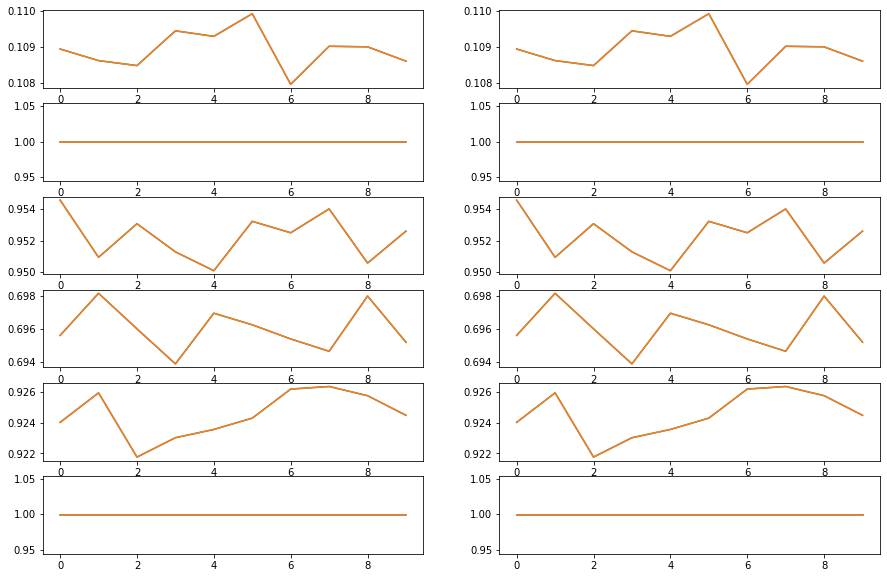

In [10]:
# Number of probes in vertical direction
Nh = 1
# Number of probes in horizontal direction
Nw = 6
height, width = stack[0].shape
h_base = np.arange(height//(2*Nh), height-height//(2*Nh)+1, height//(Nh), dtype=int)
w_base = np.arange(width//(2*Nw), width-width//(2*Nw)+1, width//(Nw), dtype=int)

ws, hs = np.meshgrid(w_base, h_base)
ws, hs = ws.flatten(), hs.flatten()

plt.imshow(stack[0])
plt.plot(ws,hs,'r+')
plt.show()

probe_signal = np.empty((Nh*Nw, stack.shape[0]))
sigmas = np.empty(Nh*Nw)
# First pass to estimate the noise standard deviation
for i in range(Nh*Nw):
    probe_signal[i] = stack[:,hs[i],ws[i]]
    # Denoise
    sigmas[i] = estimate_sigma(probe_signal[i])
sigma = 1*np.max(sigmas)

# Now denoise
plt.rcParams["figure.figsize"] = (15,10)
figure, ax = plt.subplots(nrows=Nh*Nw, ncols=2)
for i in range(Nh*Nw):   
    probe_denoised = denoise_wavelet(probe_signal[i], sigma=sigma, **denoise_kwargs)
    ax[i,0].plot(probe_signal[i])
    ax[i,0].plot(probe_denoised)
    ax[i,1].plot(probe_signal[i][:60])
    ax[i,1].plot(probe_denoised[:60])
plt.show()

If we are happy with results on the probes, do this for the whole stack (this can take a while):

In [11]:
stack_denoised = np.empty_like(stack)
#stack_denoised = stack.copy()

for i in tqdm(range(height)):
    for j in range(width):
        stack_denoised[:, i, j] = denoise_wavelet(stack[:, i, j], sigma=sigma, **denoise_kwargs)

  0%|          | 0/1200 [00:00<?, ?it/s]

Let's inspect the result on one image at time `t`:

IndexError: index 60 is out of bounds for axis 0 with size 10

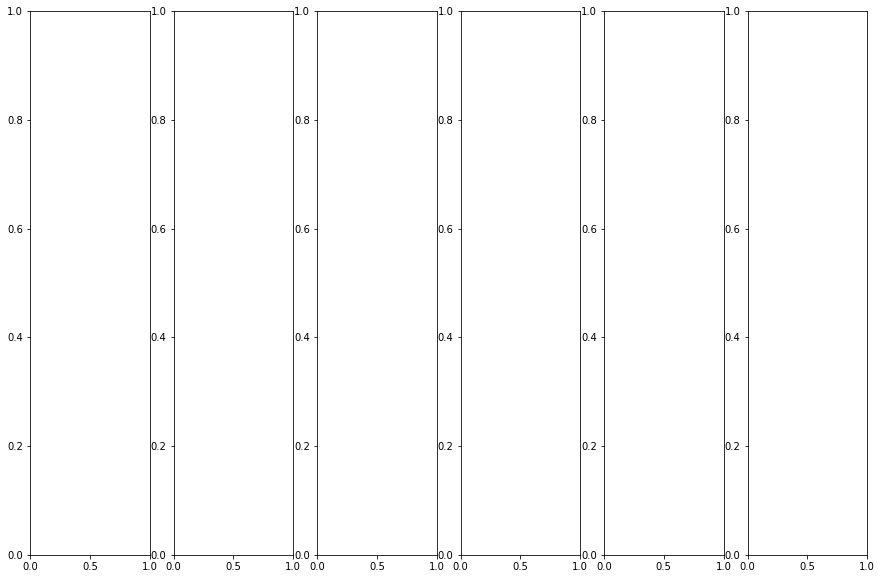

In [12]:
t = 60
plt.rcParams["figure.figsize"] = (15,10)
figure, ax = plt.subplots(ncols=6)
ax[0].imshow(stack[t], vmin=0, vmax=1)
ax[1].imshow(stack_denoised[t], vmin=0, vmax=1)
ax[2].imshow(stack[t, height//3:2*height//3, width//3:2*width//3], vmin=0, vmax=1)
ax[3].imshow(stack_denoised[t, height//3:2*height//3, width//3:2*width//3], vmin=0, vmax=1)
ax[4].imshow(stack[t, 4*height//9:5*height//9, 4*width//9:5*width//9], vmin=0, vmax=1)
ax[5].imshow(stack_denoised[t, 4*height//9:5*height//9, 4*width//9:5*width//9], vmin=0, vmax=1)
plt.show()

## Spatial filtering of the absorbance using wavelets

The absorbance field is direclty linked to concentration (either proportional, or the result of some smooth transformation), therefore this field should be smooth in the gel.

We start with defining the absorbance and 'repare' outliers.

In [13]:
A = -np.log10(stack_denoised/stack_denoised[0])
A[np.isnan(A)] = 0.
A[A<0] = 0.

We now create a mask that identifies the probe shadow. This is done in two steps:

1. Identify the interior of the probe which may by semi-transparent.
2. Identify all other pixels where the back-light intensity is not sufficient.

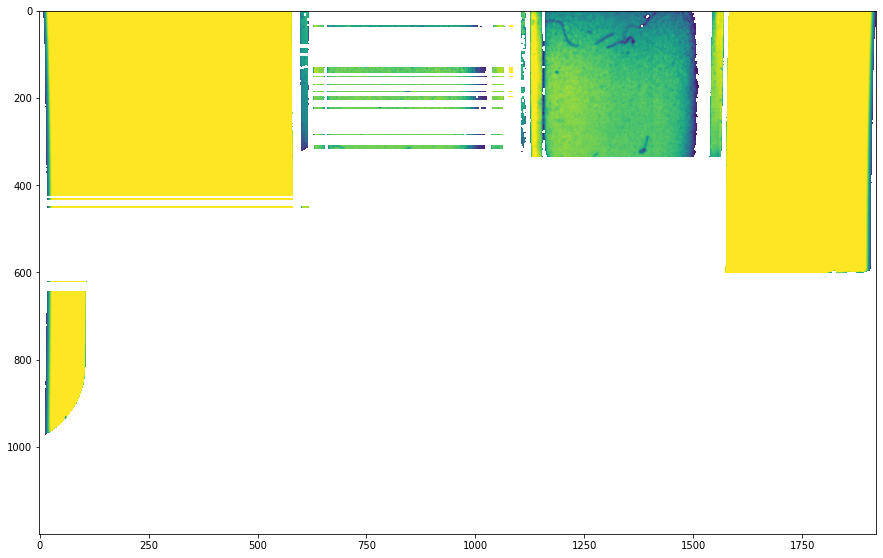

In [14]:
## Create mask
mask = stack_denoised[0].copy()

# Probe envelope
min_intensity = 0.3

for i, line in enumerate(mask):
    # For each line
    j_min, j_max = -1, -1
    for j, value in enumerate(line):
        if value < min_intensity:
            if j_min == -1:
                j_min = j
            j_max = j
    if j_min > -1:
        mask[i, j_min:j_max] = np.nan

# Minimum backlight intensity in general
min_intensity_gen = 0.7
mask[mask<min_intensity_gen] = np.nan
        
plt.imshow(mask)
plt.show()

It will help denoising if the absorbance has some non-zero value inside the probe. We fill the probe line by line with an average of the `k` greatest values outside the probe shadow:

In [15]:
k = 5
for i in tqdm(range(len(A))):
    for l, line in enumerate(A[i]):
        # Line by line
        largest = np.partition(-A[i,l][~np.isnan(mask[l])], k)[:k]
        value = -np.average(largest)
        A[i,l][np.isnan(mask[l])] = value

  0%|          | 0/10 [00:00<?, ?it/s]

c:\users\fiam irc\appdata\local\programs\python\python39\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\users\fiam irc\appdata\local\programs\python\python39\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: kth(=5) out of bounds (5)

Let's inspect the result:

In [16]:
plt.imshow(A[100])
plt.show()

IndexError: index 100 is out of bounds for axis 0 with size 10

Now we are ready to perform the spatial filtering. This is done with a standard wavelet denoising algorithm from the `skimage.restoration` module. Parameters are stored in the following dictionary:

In [17]:
from skimage.restoration import denoise_wavelet, estimate_sigma

denoise_kwargs = {'wavelet': 'sym4', 
                  'mode': 'soft',
                  'method': 'VisuShrink'
                  }

Let's try the denoising on one absorbance image at time `t` first.

In [18]:
t = 60
sigma_est = estimate_sigma(A[t])
denoised_img = denoise_wavelet(A[t], sigma= sigma_est, **denoise_kwargs)

plt.rcParams["figure.figsize"] = (15,10)
figure, ax = plt.subplots(ncols=6)
vmin = np.min(A[t])
vmax = np.max(A[t])
ax[0].imshow(A[t], vmin=vmin, vmax=vmax)
ax[1].imshow(denoised_img, vmin=vmin, vmax=vmax)
ax[2].imshow(A[t, height//3:2*height//3, width//3:2*width//3], vmin=vmin, vmax=vmax)
ax[3].imshow(denoised_img[height//3:2*height//3, width//3:2*width//3], vmin=vmin, vmax=vmax)
ax[4].imshow(A[t, 4*height//9:5*height//9, 4*width//9:5*width//9], vmin=vmin, vmax=vmax)
ax[5].imshow(denoised_img[4*height//9:5*height//9, 4*width//9:5*width//9], vmin=vmin, vmax=vmax)
plt.show()

IndexError: index 60 is out of bounds for axis 0 with size 10

We can also inspect a single line:

In [19]:
def slice(line):
    plt.plot(A[t, line], label='Raw')
    plt.plot(denoised_img[line], label='Denoised')
    plt.legend()
    plt.show()


w2 = interactive(slice, line=widgets.IntSlider(value=height//2,min=0,max=height-1, continuous_update=False))
w2

interactive(children=(IntSlider(value=600, continuous_update=False, description='line', max=1199), Output()), …

If we are happy, let's do it for the whole stack:

In [20]:
A_denoised = np.empty_like(A)
#A_denoised = A.copy()

for i, im in tqdm(enumerate(A), total=len(list_files)):
    sigma_est = estimate_sigma(im)
    A_denoised[i] = denoise_wavelet(im, sigma= sigma_est, **denoise_kwargs)

  0%|          | 0/10 [00:00<?, ?it/s]

## Write results to a file

We store the denoised stack, denoised absorbance and the shadow mask in a compressed file:

In [21]:
np.save('absorbance', A_denoised)
np.save('mask', mask)
np.save('im0', stack_denoised[0])

# Uncomment this line to save denoised image stack as well:
#np.save('stack', stack_denoised)